# Sistem Rekomendasi Berita

dataset berita dari https://www.kaggle.com/datasets/sh1zuka/indonesia-news-dataset-2024

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import joblib
import os

In [2]:
# Download stopwords
nltk.download('stopwords', quiet=True)

True

In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/indonesia-news-dataset-2024/politik_merge.csv')
print("Dataset loaded successfully.")
print(f"Shape of dataset: {df.shape}")
print("Columns:", df.columns.tolist())

Dataset loaded successfully.
Shape of dataset: (45781, 10)
Columns: ['Judul', 'Waktu', 'Link', 'Content', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5', 'source']


## Preproses
Fungsi preprocess_text melakukan pembersihan dan normalisasi teks:
* Mengubah teks menjadi lowercase
* Menghapus tanda baca
* Menghapus angka
* Menghapus stopwords bahasa 

Preprocessing ini diterapkan pada kolom 'Content' dari dataframe.

In [40]:
# Preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [5]:
# Apply preprocessing to 'Content' column
df['processed_content'] = df['Content'].apply(preprocess_text)


## TF-IDF Vectorization
TF-IDF digunakan untuk mengubah teks menjadi vektor numerik, memperhitungkan frekuensi kata dalam dokumen dan kepentingannya dalam seluruh korpus.

In [6]:
# Create TF-IDF matrix
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['processed_content'])

## Cosine Similarity
Cosine similarity digunakan untuk mengukur kesamaan antara dokumen berdasarkan representasi TF-IDF mereka.

In [7]:
def batch_cosine_similarity(X, batch_size=1000):
    n_samples = X.shape[0]
    cosine_sim = np.zeros((n_samples, n_samples))
    
    for i in range(0, n_samples, batch_size):
        batch = X[i:i+batch_size]
        cosine_sim[i:i+batch_size] = cosine_similarity(batch, X)
    
    return cosine_sim

In [10]:
# Check if cosine similarity matrix exists, if not, compute and save it
cosine_sim_file = 'cosine_sim.joblib'
if os.path.exists(cosine_sim_file):
    cosine_sim = joblib.load(cosine_sim_file)
else:
    cosine_sim = batch_cosine_similarity(tfidf_matrix)
    joblib.dump(cosine_sim, cosine_sim_file)

## Rekomendasi

In [31]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Cek apakah judul ada dalam DataFrame
    if title not in df['Judul'].values:
        return None, None  # Kembalikan None jika judul tidak ditemukan
    
    idx = df[df['Judul'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 similar items
    news_indices = [i[0] for i in sim_scores]
    recommended_titles = df['Judul'].iloc[news_indices]
    similarity_scores = [i[1] for i in sim_scores]
    return recommended_titles, similarity_scores

In [32]:
# Example usage
print("\nContoh Rekomendasi:")
sample_title = df['Judul'].iloc[0]  # Mengambil judul pertama sebagai contoh
print(f"Berita: {sample_title}")
print("\nRekomendasi berita serupa:")
recommendations = get_recommendations(sample_title)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")


Contoh Rekomendasi:
Berita: Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta

Rekomendasi berita serupa:
1. 43449    KSP: Pakaian Adat Betawi Presiden Simbol Terim...
18064    7 Pakaian Adat yang Dikenakan Jokowi Saat Pida...
33840    Tentang Baju Kustin, Pakaian Adat Jokowi Saat ...
16692    Daftar Nama Pakaian Adat di Indonesia untuk Up...
31419    Daftar Nama Pakaian Adat di Indonesia untuk Up...
30419    Daftar Pencalonan ke KPUD, Pramono Kenakan Baj...
32512    Daftar Baju Adat yang Pernah Dipakai Jokowi sa...
39555    Jokowi Pakai Baju Adat Banjar di Upacara Penur...
44029    Pegiat HAM Sebut Pejabat Pakai Baju Adat Hanya...
28826    Jokowi di HUT RI IKN, Pakai Baju Adat Nusantar...
Name: Judul, dtype: object
2. [0.9105183650910083, 0.7646547548277388, 0.5212104734929698, 0.5190423547246903, 0.5190423547246903, 0.4916265913755784, 0.4869250179047363, 0.4867819636478422, 0.47039985688304653, 0.4605385712523682]


## Pencarian

In [13]:
# Fungsi untuk mencari berita berdasarkan kata kunci
def search_news(keyword):
    return df[df['processed_content'].str.contains(keyword, case=False, na=False)]['Judul']


In [14]:
# Contoh pencarian
print("\nContoh Pencarian:")
keyword = "presiden"  # Ganti dengan kata kunci yang Anda inginkan
search_results = search_news(keyword)
print(f"Hasil pencarian untuk '{keyword}':")
for i, title in enumerate(search_results[:5], 1):  # Menampilkan 5 hasil pertama
    print(f"{i}. {title}")


Contoh Pencarian:
Hasil pencarian untuk 'presiden':
1. Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta
2. Amnesty International Beberkan 6 Indikator Krisis Demokrasi di Indonesia
3. Saat ASN Solo Ikut Lepas Gibran yang Resmi Mundur Menjelang Pelantikan Wakil Presiden
4. Airlangga Hartarto Mundur dari Ketum, Golkar Bantah karena Korupsi dan Fokus Cari Pengganti
5. Gibran Akan Bertemu Jokowi dan Prabowo Setelah Lebaran di Solo


## Sentimen

In [19]:
# Analisis Sentimen
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [22]:
# Sebelum melakukan analisis atau visualisasi, mengganti nilai inf
df['Content'] = df['Content'].replace([np.inf, -np.inf], np.nan)

# Kemudian lanjutkan analisis sentiment
df['Content'] = df['Content'].astype(str)
df['sentiment'] = df['Content'].apply(analyze_sentiment)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


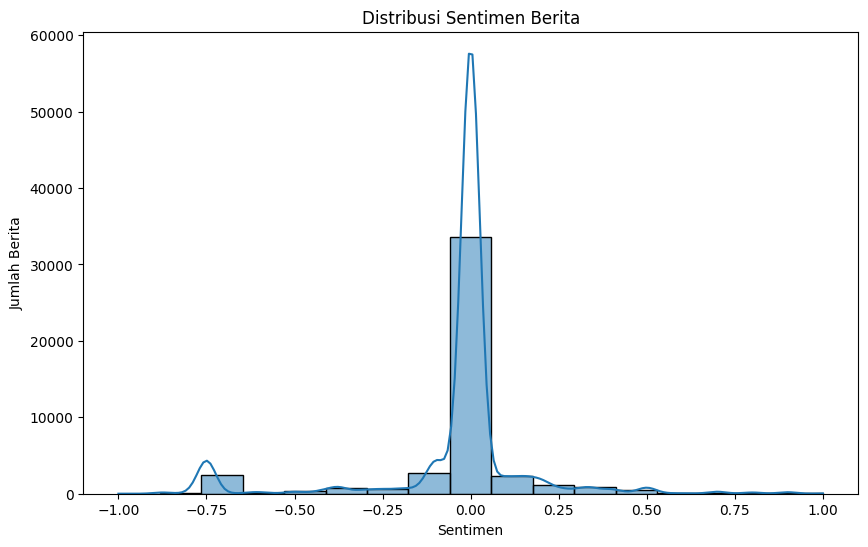

In [24]:
# Visualisasi
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Distribusi Sentimen Berita')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Berita')
plt.show()

Analisis:
* Distribusi Sentral: Mayoritas besar berita memiliki sentimen netral atau mendekati netral (sekitar 0 pada skala sentimen).
* Simetri: Distribusi cenderung simetris, dengan sedikit kecenderungan ke arah sentimen positif (sisi kanan grafik).
* Outliers: Terdapat beberapa outlier di kedua ujung spektrum, menunjukkan adanya berita dengan sentimen sangat positif atau sangat negatif, meskipun jumlahnya relatif kecil.
* Puncak Tajam: Grafik menunjukkan puncak yang sangat tajam di sekitar 0, mengindikasikan bahwa sebagian besar berita cenderung netral atau objektif.
* Ekor Tipis: Ekor distribusi yang tipis menunjukkan bahwa berita dengan sentimen ekstrem (baik sangat positif maupun sangat negatif) relatif jarang.

## Interaktif

In [33]:
# Interaktivitas
while True:
    print("\n1. Cari berita")
    print("2. Dapatkan rekomendasi")
    print("3. Keluar")
    choice = input("Pilih opsi (1/2/3): ")
    
    if choice == '1':
        keyword = input("Masukkan kata kunci pencarian: ")
        results = search_news(keyword)
        print(f"\nHasil pencarian untuk '{keyword}':")
        for i, title in enumerate(results[:5], 1):
            print(f"{i}. {title}")
    
    elif choice == '2':
        title = input("Masukkan judul berita untuk rekomendasi: ")
        recommendations, scores = get_recommendations(title)
        if recommendations is None:
            print(f"Judul '{title}' tidak ditemukan dalam database.")
        else:
            print("\nRekomendasi berita serupa:")
            for i, (rec, score) in enumerate(zip(recommendations, scores), 1):
                print(f"{i}. {rec} (Similarity: {score:.2f})")
    
    elif choice == '3':
        print("Terima kasih! Sampai jumpa.")
        break
    
    else:
        print("Pilihan tidak valid. Silakan coba lagi.")


1. Cari berita
2. Dapatkan rekomendasi
3. Keluar


Pilih opsi (1/2/3):  2
Masukkan judul berita untuk rekomendasi:  Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta



Rekomendasi berita serupa:
1. KSP: Pakaian Adat Betawi Presiden Simbol Terima Kasih untuk Ibu Kota Jakarta (Similarity: 0.91)
2. 7 Pakaian Adat yang Dikenakan Jokowi Saat Pidato Kenegaraan, Betawi Jadi Pemungkas (Similarity: 0.76)
3. Tentang Baju Kustin, Pakaian Adat Jokowi Saat Upacara 17 Agustus 2024 (Similarity: 0.52)
4. Daftar Nama Pakaian Adat di Indonesia untuk Upacara 17 Agustus (Similarity: 0.52)
5. Daftar Nama Pakaian Adat di Indonesia untuk Upacara 17 Agustus (Similarity: 0.52)
6. Daftar Pencalonan ke KPUD, Pramono Kenakan Baju Adat Betawi dan Naik Opelet (Similarity: 0.49)
7. Daftar Baju Adat yang Pernah Dipakai Jokowi saat Upacara 17 Agustus (Similarity: 0.49)
8. Jokowi Pakai Baju Adat Banjar di Upacara Penurunan Bendera, Ini Maknanya (Similarity: 0.49)
9. Pegiat HAM Sebut Pejabat Pakai Baju Adat Hanya Gimik: RUU Perlindungan Masyarakat Adat Malah Enggak Dibahas (Similarity: 0.47)
10. Jokowi di HUT RI IKN, Pakai Baju Adat Nusantara Terinspirasi Adat Kustin Kukar (Similarit

Pilih opsi (1/2/3):  1
Masukkan kata kunci pencarian:  presiden



Hasil pencarian untuk 'presiden':
1. Jokowi Kenakan Pakaian Adat Betawi di Sidang Tahunan Terakhirnya, Simbol Terima Kasih untuk Jakarta
2. Amnesty International Beberkan 6 Indikator Krisis Demokrasi di Indonesia
3. Saat ASN Solo Ikut Lepas Gibran yang Resmi Mundur Menjelang Pelantikan Wakil Presiden
4. Airlangga Hartarto Mundur dari Ketum, Golkar Bantah karena Korupsi dan Fokus Cari Pengganti
5. Gibran Akan Bertemu Jokowi dan Prabowo Setelah Lebaran di Solo

1. Cari berita
2. Dapatkan rekomendasi
3. Keluar


Pilih opsi (1/2/3):  3


Terima kasih! Sampai jumpa.


## Evaluasi Model

In [38]:
# Fungsi untuk menghitung Precision at K
def precision_at_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

# Fungsi untuk menghitung Average Precision
def average_precision(actual, predicted):
    ap = 0.0
    relevant_count = 0
    for i, p in enumerate(predicted):
        if p in actual:
            relevant_count += 1
            ap += relevant_count / (i + 1)
    return ap / len(actual) if len(actual) > 0 else 0

# Fungsi untuk menghitung NDCG
def ndcg_at_k(actual, predicted, k):
    dcg = 0
    idcg = sum([1.0 / np.log2(i + 2) for i in range(min(k, len(actual)))])
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            dcg += 1.0 / np.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0

# Fungsi untuk mendapatkan berita yang mirip berdasarkan cosine similarity
def get_similar_articles(title, df, cosine_sim, threshold=0.5):
    idx = df[df['Judul'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = [i for i in sim_scores if i[1] > threshold]
    article_indices = [i[0] for i in sim_scores]
    return df['Judul'].iloc[article_indices].tolist()

# Fungsi untuk melakukan evaluasi
def evaluate_model(df, cosine_sim, num_samples=100, k=10):
    # Split data menjadi train dan test
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    precisions = []
    aps = []
    ndcgs = []
    
    for _ in range(num_samples):
        # Pilih berita secara acak dari test set
        sample = test_df.sample(n=1).iloc[0]
        actual_title = sample['Judul']
        
        # Dapatkan rekomendasi
        recommendations, _ = get_recommendations(actual_title, cosine_sim)
        
        if recommendations is not None:
            # Dapatkan artikel yang mirip sebagai "ground truth"
            actual_relevant = get_similar_articles(actual_title, df, cosine_sim)
            
            # Hitung metrik
            precisions.append(precision_at_k(actual_relevant, recommendations, k))
            aps.append(average_precision(actual_relevant, recommendations))
            ndcgs.append(ndcg_at_k(actual_relevant, recommendations, k))
    
    # Hitung rata-rata metrik
    avg_precision = np.mean(precisions)
    map_score = np.mean(aps)
    avg_ndcg = np.mean(ndcgs)
    
    return avg_precision, map_score, avg_ndcg

# Jalankan evaluasi
k = 10
avg_precision, map_score, avg_ndcg = evaluate_model(df, cosine_sim)

In [39]:
print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Mean Average Precision: {map_score:.4f}")
print(f"Average NDCG@{k}: {avg_ndcg:.4f}")

Average Precision@10: 0.6750
Mean Average Precision: 0.4581
Average NDCG@10: 0.8099
